# Inferência Variacional
---

A partir de um conjunto de dados $\mathcal{D}$, podemos tentar inferir os parâmetros de uma distribuição gaussiana que, provavelmente, gerou aqueles dados. Considerando uma gaussiana $\mathcal{N}(x | \mu, \tau^{-1})$, onde $\mu$ é a média e $\tau$ a precisão, buscamos encontrar a probabilidade a posteriori $p(\mu, \tau^{-1} | \mathcal{D})$, inferindo, assim, os parâmetros da distribuição.

A verossimilhança será dada por:

$$p(\mathcal{D} | \mu, \tau) = \prod^N_{i = 1} \mathcal{N}(x_i | \mu, \tau^{-1})$$

Assumiremos, também, uma priori conjugada para os parâmetros da gaussiana:

$$p(\mu, \tau) = \mathcal{N}(\mu | \mu_0, (\kappa_0 \tau)^{-1}) Ga(\tau | a_0, b_0) $$

A posteriori será representada de forma fatorada, sendo $q(\mu, \tau) = q_{\mu}(\mu) q_{\tau}(\tau)$.

---
Podemos encontrar $q_{\mu}(\mu)$ marginalizando $\tau$ na log-conjunta:

$$ \log q_{\mu}(\mu) = \mathbb{E}_{q_{\tau}}[\log p(\mathcal{D} | \mu, \tau) p(\mu | \tau) p(\tau)] + constante $$

$$ = - \frac{\mathbb{E}_{q_{\tau}}[\tau]}{2} \left[ \mu^2(\kappa_0 + N) - 2\mu \left( \kappa_0 \mu_0 + \sum^N_{i = 1} x_i \right) \right] + constante $$

$$ = \log \mathcal{N}(\mu | \mu_N, \kappa_N^{-1}) \propto - \frac{\kappa_n}{2}(\mu^2 - 2\mu \mu_N + \mu^2_N)$$

Assim, temos que a fórmula ótima de $q_{\mu}(\mu)$ será a gaussiana $\mathcal{N}(\mu | \mu_N, \kappa_N^{-1})$, onde:

$$\mu_N = \frac{\kappa_0 \mu_0 + \sum^N_{i=1} x_i}{\kappa_0 + N} $$

$$ \kappa_N = (\kappa_0 + N)\mathbb{E}_{q_{\tau}}[\tau] $$

Onde $\mathbb{E}_{q_{\tau}}[\tau]$ será calculado quando obtivermos a forma de $q_{\tau}(\tau)$ .

---
De forma análoga, podemos encontrar $q_{\tau}(\tau)$, marginalizando $\mu$ na log-conjunta:

$$\log q_{\tau}(\tau) = \mathbb{E}_{q_{\mu}}[\log p(\mathcal{D} | \mu, \tau) + \log p(\mu | \tau) + \log p(\tau)] + constante $$

$$ = -\tau \left[ b_0 + \frac{1}{2} \mathbb{E}_{q_{\mu}}\left(\sum^N_{i=1} (x_i - \mu)^2 + \kappa_0(\mu-\mu_0)\right)\right] + constante $$

$$ \log Ga(\tau | a_N, b_N) \propto (a_N - 1) \log \tau - b_N \tau $$

Assim, temos que a fórmula ótima de $q_{\tau}(\tau)$ será a gamma $Ga(\tau | a_N, b_N)$, onde:

$$a_N = a_0 + \frac{N+1}{2} $$

$$b_N = b_0 + \frac{\kappa_0}{2}(\mathbb{E}_{q_{\mu}}[\mu^2] - 2\mathbb{E}_{q_{\mu}}[\mu]\mu_0 + \mu_0^2) + \frac{1}{2}\sum^N_{i=1}(x_i^2 - 2x_i\mathbb{E}_{q_{\mu}}[\mu] + \mathbb{E}_{q_{\mu}}[\mu^2]) $$

Agora, podemos computar as esperanças necessárias:

$$ \mathbb{E}_{q_{\tau}}[\tau] = \frac{a_N}{b_N} $$

$$\mathbb{E}_{q_{\mu}}[\mu] = \mu_N $$

$$\mathbb{E}_{q_{\mu}}[\mu^2] = \frac{1}{\kappa_N} + \mu_N^2 $$

---
Em resumo, as atualizações são as seguintes:

$$q_{\mu}(\mu) = \mathcal{N}(\mu | \mu_N, \kappa_N^{-1}), \hspace{0.5cm} \mu_N = \frac{\kappa_0 \mu_0 + \sum^N_{i=1} x_i}{\kappa_0 + N}, \hspace{0.5cm} \kappa_N = (\kappa_0 + N)\frac{a_N}{b_N}$$

$$q_{\tau}(\tau) = Ga(\tau | a_N, b_N), \hspace{0.5cm} a_N = a_0 + \frac{N+1}{2} \hspace{0.5cm} b_N = b_0 + \frac{\kappa_0}{2}(\frac{1}{\kappa_N} + \mu_N^2 - 2\mu_N\mu_0 + \mu_0^2) + \frac{1}{2}\sum^N_{i=1}(x_i^2 - 2x_i\mu_N + \frac{1}{\kappa_N} + \mu_N^2)$$

É importante observar que $\mu_N$ e $a_N$ são valores fixos, mas, devido a sua dependência cíclica, $\mu_N$ e $b_N$ precisam ser atualizados iterativamente

In [1]:
%matplotlib inline
import numpy as np
from scipy.stats import multivariate_normal, gamma, norm
import matplotlib.pyplot as plt

Vamos iniciar nossa inferência, visualizando o dataset

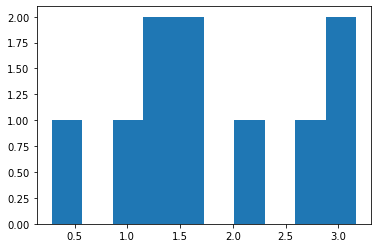

In [2]:
X = np.loadtxt("gaussian_1d.csv", delimiter=',')
_ = plt.hist(X)

Agora, vamos implementar os cálculos descritos anteriormente

In [3]:
def fit(X, mean_0, k_0, a_0, b_0, itter=5):
    N = X.shape[0]
    
    mean = (k_0*mean_0 + np.sum(X)) / (k_0 + N)
    a = a_0 + (N+1)/2
    
    k = k_0
    b = b_0
    
    mean_diff = (mean - mean_0)**2
    X_diff = (X - mean)**2
    
    for i in range(itter):
        k = (k_0 + N) * a / b
        b = b_0 + (k_0/2)*((1/k) + mean_diff) + 0.5*np.sum((1/k) + X_diff)
    
    post_mean = lambda m: norm(mean, 1/k).pdf(m)
    
    post_tau = lambda t: gamma(a=a,scale=1/b).pdf(t)
    
    return (mean, 1/k, post_mean), (a/b, post_tau)

# definição da priori para tau
a_0 = 2
b_0 = 1
priori_tau = lambda t: gamma(a=a_0,scale=1/b_0).pdf(t)

# definição da priori para mu
mean_0 = 0
tau_0 = 1
k_0 = 1
priori_mean = lambda m: norm(mean_0, 1/(k_0*tau_0)).pdf(m)

Agora, vamos experimentar o comportamento das inferências, variando o tamanho da amostra

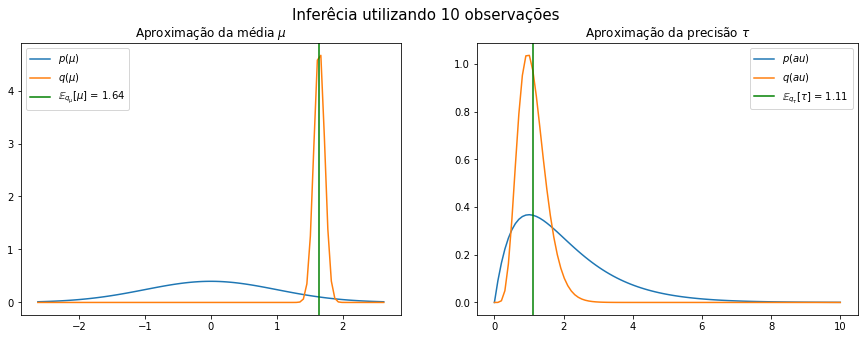

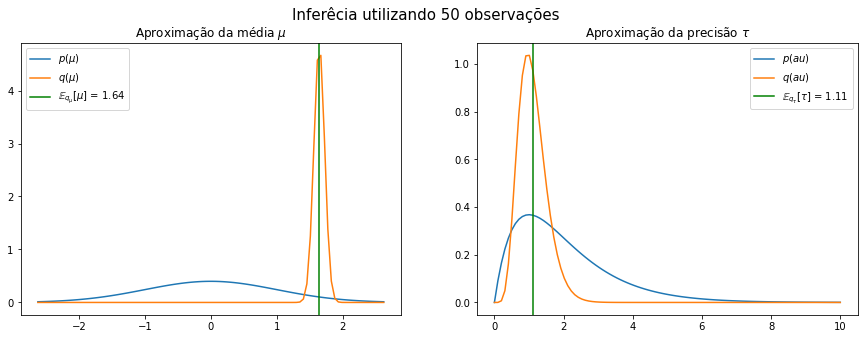

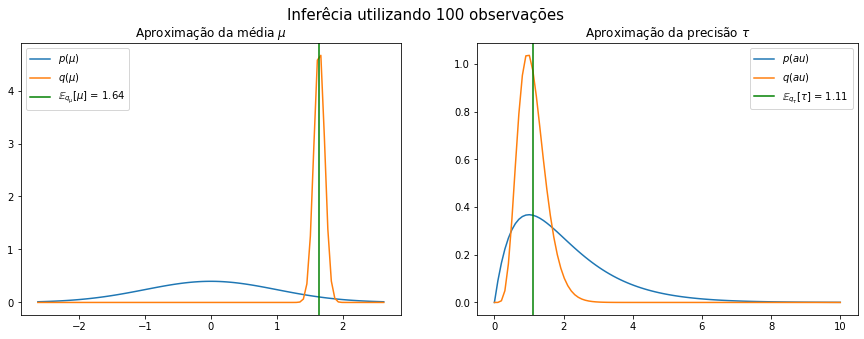

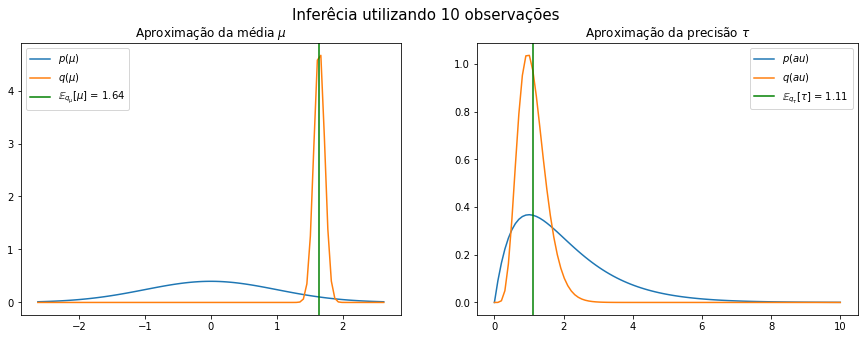

In [4]:
for n in [10, 50, 100, len(X)]:
    (expected_mean, var_mean, post_mean), (expected_tau, post_tau) = fit(X[:n], mean_0, k_0, a_0, b_0)

    fig = plt.figure(figsize=(15,5))
    fig.suptitle(f"Inferêcia utilizando {n} observações", fontsize=15)
    
    plt.subplot(1,2,1)
    margin = 3*np.sqrt(X.var())
    m = np.linspace(-margin, margin, 100) + mean_0
    plt.plot(m, priori_mean(m), label="$p(\mu)$")
    plt.plot(m, post_mean(m), label="$q(\mu)$")
    plt.gca().axvline(x=expected_mean, color="g", label="$\mathbb{E}_{q_{\mu}}[\mu]$ = " + str(np.round(expected_mean, 2)))
    plt.legend()
    plt.title("Aproximação da média $\mu$")
    
    plt.subplot(1,2,2)
    t = np.linspace(0, 10, 100)
    plt.plot(t, priori_tau(t), label="$p(\tau)$")
    plt.plot(t, post_tau(t), label="$q(\tau)$")
    plt.gca().axvline(x=expected_tau, color="g", label="$\mathbb{E}_{q_{\\tau}}[\\tau]$ = " + str(np.round(expected_tau,2)))
    plt.legend()
    plt.title("Aproximação da precisão $\\tau$")